In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import datetime
import numpy as np
import torch
import torch.nn.functional as F

torch.autograd.set_detect_anomaly(True)
# torch.set_default_dtype(torch.float32)

import mediapy as mpy
from tqdm.auto import tqdm
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
import wandb

from nca_model import SimpleNCA
from utils import nca_out_to_vids, tonp, save_model, load_latest_model, nca_cmap, pad_to, nca_clamp
from data import (
    MNISTPatternGenerator,
    MNISTPatternPool,
    generate_radial_circles_pattern,
    generate_canonical_mnist_digits,
)

In [4]:
device = "cuda"
num_classes = 10
channs = 16
bs = 32
S = 80
lr = 0.0008
pool_size = 64
pool_replacement = 0.8

In [5]:
nca = SimpleNCA(channs).to(device)

In [6]:
inp = torch.rand(5, channs, S, S).to(device)
out = nca(inp, steps=50)
len(out), out[0].shape

(51, torch.Size([5, 16, 80, 80]))

,,,,

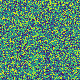
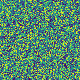
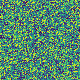
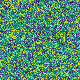
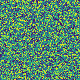

In [7]:
nca_out_to_vids(out)

In [8]:
pattern = generate_radial_circles_pattern(S, num_classes)
pool = MNISTPatternPool(
    is_train=True, channs=channs, size=S, pool_size=pool_size, pattern=pattern,
    replacement=pool_replacement
)
sample = pool.sample(bs=bs)
inp = sample.batch["inp"][:, :3]
out = sample.batch["out"]

,,,,,,,,,

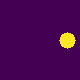
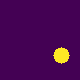
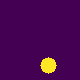
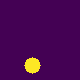
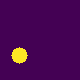
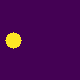
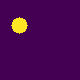
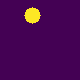
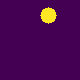
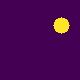

In [9]:
mpy.show_images(pattern, cmap="viridis", width=150)

,,,,,,,

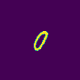
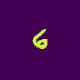
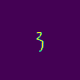
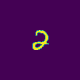
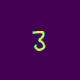
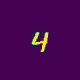
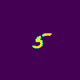
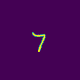

,,,,,,,

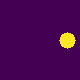
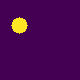
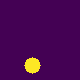
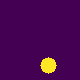
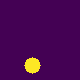
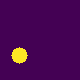
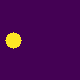
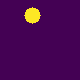

In [10]:
mpy.show_images(inp[:8,0], cmap="viridis", width=100, columns=8)
mpy.show_images(out[:8, 0], cmap="viridis", width=100, columns=8)

In [11]:
nca = SimpleNCA(channs, alive_mask=False).to(device)
# with open(".checkpoints/nca-80-radial/nca-49750-[2025-05-07-22-16-01].pkl", "rb") as fp:
#     nca = torch.load(fp).to(device)

In [14]:
train_gen = MNISTPatternGenerator(
    is_train=True, channs=channs, pattern=pattern, bs=bs
)

optim = torch.optim.Adam(nca.parameters(), lr=lr)
history = []

In [21]:
os.environ["WANDB_NOTEBOOK_NAME"] = "./train-radial-circles.ipynb"

experiment_name = "nca-80-radial-2-continue"

run = wandb.init(
    project="nca-classifier",
    name=experiment_name,
    save_code=True,
)
_ = run.log_code(
    "./",
    include_fn=lambda path: path.endswith(".py") or path.endswith(".ipynb"),
)

Loss: 0.0096164662:   3%|2         | 2750/100000 [26:56<14:24:24,  1.88it/s]

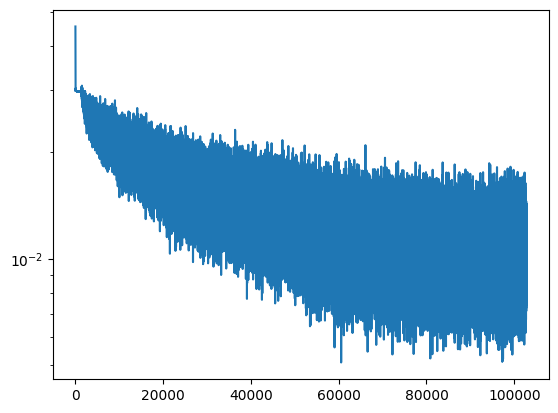

In [ ]:
pbar = tqdm(range(100_000, 200_000))

for i in pbar:
    batch = next(train_gen)
    inp, out_gt = batch["inp"], batch["out"]
    out_gt = out_gt.to(device)[:, 0]

    steps = np.random.randint(30, 45)
    out_pred = nca(inp.to(device), steps=steps)
    last_step = out_pred[-1]
    last_frame = last_step[:, 0]

    losses = F.mse_loss(last_frame, out_gt, reduction="none")
    losses = losses.reshape(bs, -1).mean(axis=1)
    loss = losses.mean()

    optim.zero_grad()
    loss.backward()
    optim.step()

    pbar.set_description(f"Loss: {loss:.10f}")
    run.log({"loss": loss.item()})

    history.append(loss.item())

    if i % 250 == 0:
        clear_output()
        display(pbar.container)
        
        plt.plot(history)
        plt.yscale("log")
        plt.show()

        save_model(nca, experiment_name, i)

        with torch.inference_mode():
            out_pred = nca(inp.to(device), steps=50)
            nca_out_to_vids(out_pred, columns=8)

            run.log({"train_example": [
                wandb.Video(v, fps=20) for v in nca_cmap(out_pred)
            ]})

In [18]:
run.finish()

loss,█▆▅▅▃▄▃▃▃▄▃▂▃▃▃▃▃▂▃▂▃▂▂▁▁▁▂▃▂▂▄▃▃▂▂▃▂▁▁▁
loss,0.00976


In [20]:
np.array(history).argsort()[0]

60554

In [19]:
1

1